In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import datetime

#for BERT
import transformers

In [3]:
# GPU options to limit OOM erors
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12532158316837129213
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22723493888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10113625611560698036
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
2.5.0


In [5]:
#make sure csv only contains labelled examples
#in excel, have concat title and abstract into same text block = feature. 
labelled = pd.read_csv('training_data/training_main_classifier.csv', index_col=0)

In [6]:
analysisdf = labelled[['pmid', 'include', 'feature']].copy()       
                      
#pipeline now independent from csv
analysisdf['include'] = analysisdf['include'].astype(np.int64)
analysisdf.head()

,pmid,include,feature
0,28278461,1,Automatic Quantification of Tumour Hypoxia Fro...
2,32660549,1,A decision support system based on support vec...
4,32079910,1,Posture and Physical Activity Detection: Impac...
7,29127485,1,OCT-based deep learning algorithm for the eval...
8,30815461,1,Blood Pressure Assessment with Differential Pu...


In [7]:
analysisdf = analysisdf.drop(['pmid'], axis=1)

labels:
0    9203
1    2276
Name: include, dtype: int64


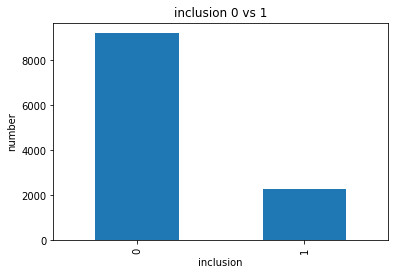

In [8]:
print("labels:")
print(analysisdf['include'].value_counts())

plt.figure()
pd.value_counts(analysisdf['include']).plot.bar(title="inclusion 0 vs 1")
plt.xlabel("inclusion")
plt.ylabel("number")
plt.show()

In [9]:
analysisdf[analysisdf['feature'].isna()]

,include,feature


In [10]:
#analysisdf.dropna(subset=['feature'], inplace=True)

## creating training/validation, and test sets

tempdf


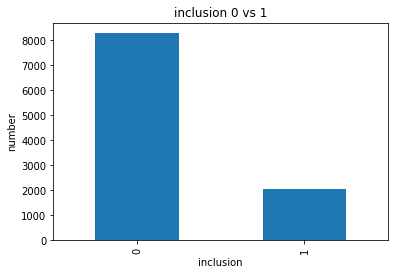

valdf


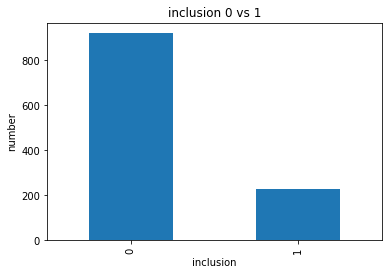

In [11]:
from sklearn.model_selection import train_test_split

tempdf, valdf = train_test_split(analysisdf, test_size=0.1, stratify=analysisdf['include'])

print("tempdf")
plt.figure()
pd.value_counts(tempdf['include']).plot.bar(title="inclusion 0 vs 1")
plt.xlabel("inclusion")
plt.ylabel("number")
plt.show()

print("valdf")
plt.figure()
pd.value_counts(valdf['include']).plot.bar(title="inclusion 0 vs 1")
plt.xlabel("inclusion")
plt.ylabel("number")
plt.show()

traindf


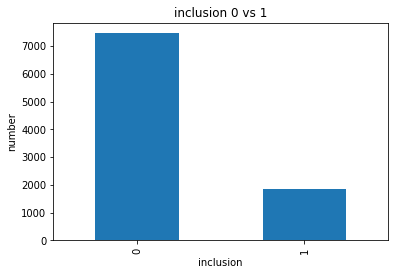

testdf


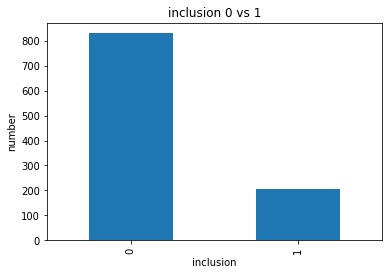

In [12]:
traindf, testdf = train_test_split(tempdf, test_size=0.1, stratify=tempdf['include'])

print("traindf")
plt.figure()
pd.value_counts(traindf['include']).plot.bar(title="inclusion 0 vs 1")
plt.xlabel("inclusion")
plt.ylabel("number")
plt.show()

print("testdf")
plt.figure()
pd.value_counts(testdf['include']).plot.bar(title="inclusion 0 vs 1")
plt.xlabel("inclusion")
plt.ylabel("number")
plt.show()

In [13]:
pd.set_option('display.max_colwidth', None)

traindf.head(10)

,include,feature
7376,0,"Mathematics reflecting sensorimotor organization. This review combines short presentations of several mathematical approaches that conceptualize issues in sensorimotor neuroscience from different perspectives and levels of analysis. The intricate organization of neural structures and sensorimotor performance calls for characterization using a variety of mathematical approaches. This review points out the prospects for mathematical neuroscience: in addition to computational approaches, there is a wide variety of mathematical approaches that provide insight into the organization of neural systems. By starting from the perspective that provides the greatest clarity, a mathematical approach avoids specificity that is inaccurate in characterizing the inherent biological organization. Approaches presented include the mathematics of ordered structures, motion-phase space, subject-coincident coordinates, equivalence classes, topological biodynamics, rhythm space metric, and conditional dynamics. Issues considered in this paper include unification of levels of analysis, response equivalence, convergence, relationship of physics to motor control, support of rhythms, state transitions, and focussing on low-dimensional subspaces of a high-dimensional sensorimotor space."
8905,0,"Hypothesis test of mediation effect in causal mediation model with high-dimensional continuous mediators. Causal mediation modeling has become a popular approach for studying the effect of an exposure on an outcome through a mediator. However, current methods are not applicable to the setting with a large number of mediators. We propose a testing procedure for mediation effects of high-dimensional continuous mediators. We characterize the marginal mediation effect, the multivariate component-wise mediation effects, and the L2 norm of the component-wise effects, and develop a Monte-Carlo procedure for evaluating their statistical significance. To accommodate the setting with a large number of mediators and a small sample size, we further propose a transformation model using the spectral decomposition. Under the transformation model, mediation effects can be estimated using a series of regression models with a univariate transformed mediator, and examined by our proposed testing procedure. Extensive simulation studies are conducted to assess the performance of our methods for continuous and dichotomous outcomes. We apply the methods to analyze genomic data investigating the effect of microRNA miR-223 on a dichotomous survival status of patients with glioblastoma multiforme (GBM). We identify nine gene ontology sets with expression values that significantly mediate the effect of miR-223 on GBM survival."
4804,1,"Heart Rate Monitoring using Sparse Spectral Curve Tracing. Heart rate (HR) monitoring under real-world activities of daily living conditions is challenging, particularly, using peripheral wearable devices integrated with simple optical and acceleration sensors. The study presents a novel technique, named as CurToSS: CURve Tracing On Sparse Spectrum, for continuous HR estimation in daily living activity conditions using simultaneous photoplethysmogram (PPG) and triaxial-acceleration signals. The performance validation of HR estimation using the CurToSS algorithm is conducted in four public databases with distinctive study groups, sensor types, and protocols involving intense physical and emotional exertions. The HR performance of this time-frequency curve tracing method is also compared to that of contemporary algorithms. The results suggest that the CurToSS method offers the best performance with significantly (P<0.01) lowest HR error compared to spectral filtering and multi-channel PPG correlation methods. The current HR performances are also consistently better than a deep learning approach in diverse datasets. The proposed algorithm is powerful for reliable long-term HR monitoring under ambulatory daily life conditions using wearab

## tensor wrappers

from_tensor_slices creates a tensor wrapper that combines training features with labels

In [14]:
##TRAINING WRAPPER
train_ds = tf.data.Dataset.from_tensor_slices((traindf['feature'].to_numpy().reshape(-1,1),
                                               traindf['include'].to_numpy().reshape(-1,1)))

In [15]:
##VALIDATION WRAPPER
val_ds = tf.data.Dataset.from_tensor_slices((valdf['feature'].to_numpy().reshape(-1,1),
                                             valdf['include'].to_numpy().reshape(-1,1)))

In [16]:
##TEST SET WRAPPER
test_ds = tf.data.Dataset.from_tensor_slices((testdf['feature'].to_numpy().reshape(-1,1),
                                              testdf['include'].to_numpy().reshape(-1,1)))

## Batch and optimise datasets

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [18]:
batch_size = 8

train_ds_batched = configure_for_performance(train_ds)
val_ds_batched = configure_for_performance(val_ds)
test_ds_batched = configure_for_performance(test_ds)

## Configuring BERT: 1) preprocessing 2) vectorization

Code is largely adapted from here (also has links to other BERT libraries): https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [19]:
# BERT model for vectorization

bert_vec_model = 'experts_pubmed'

map_name_to_handle = {
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_vec_model]

bert_model = hub.KerasLayer(tfhub_handle_encoder) #wraps this as a Keras layer

INFO:absl:Using C:\Users\JOEZ~1\AppData\Local\Temp\tfhub_modules to cache modules.


In [20]:
#BERT model for pre-processing

map_model_to_preprocess = {
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_preprocess = map_model_to_preprocess[bert_vec_model]

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess) #wraps this as a Keras layer

In [21]:
print(f'BERT model selected: {tfhub_handle_encoder}')
print(f'Pre-process model selected: {tfhub_handle_preprocess}')

BERT model selected: https://tfhub.dev/google/experts/bert/pubmed/2
Pre-process model selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [22]:
#check bert_preprocess_model on test text - preprocessing should split tokens into word ids / mask /type

text_test = ['This artificial intelligence model predicts cardiovascular risk from echocardiogram images']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  7976  4454  2944 16014  2015 22935  3891  2013  9052 11522]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [23]:
#check bert_model is functional for given inputs

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/google/experts/bert/pubmed/2
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.32493797 -0.08269644  0.43817562 -0.00690068 -0.62928677  0.05597171
  0.4818498   0.99116695  0.3956298  -0.67973065  0.58589137 -0.84271526]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[-0.33714035 -0.08289197  0.46994045 ...  0.90201384  0.09892417
   0.4827702 ]
 [-0.43940446 -0.53751194  0.9816394  ... -0.1439727   0.04650824
  -1.0800732 ]
 [-0.37110242  0.54176795  1.1818852  ...  0.6468271   1.2018124
  -0.12319165]
 ...
 [-0.26433367  0.506499   -0.15520334 ... -0.1534574  -0.32176602
   2.5074317 ]
 [ 1.027251    1.5112157   0.9053338  ...  0.43650022  0.8284113
   0.36862728]
 [ 1.0718784   1.1523868   0.58389664 ...  0.7688351   0.5206408
  -0.4710126 ]]


## Building BERT classifier pipeline

This pipeline will: take raw data wrappers -> pre-process and encode with BERT (using Keraslayers defined above) -> classify using simple net

In [24]:
def build_classifier_model(seq_length=512):

    # Define input layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text_input")
    
    # Load the pretrained preprocessor
    bert_preprocessor = hub.load(tfhub_handle_preprocess)
    
    # Tokenize the input text
    tokenizer = hub.KerasLayer(bert_preprocessor.tokenize, name='tokenizer')
    tokenized_inputs = [tokenizer(text_input)]

    # Pack the tokenized input for the encoder
    bert_pack_inputs = hub.KerasLayer(bert_preprocessor.bert_pack_inputs,
                                      arguments=dict(seq_length=seq_length), name='packer')
    
    encoder_inputs = bert_pack_inputs(tokenized_inputs)
    
    #BERT encoding layer
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    #Output layers
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    
    return tf.keras.Model(text_input, net)

In [25]:
classifier_model = build_classifier_model()

classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
tokenizer (KerasLayer)          (None, None, None)   0           text_input[0][0]                 
__________________________________________________________________________________________________
packer (KerasLayer)             {'input_mask': (None 0           tokenizer[0][0]                  
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'sequence_output':  109482241   packer[0][0]                     
                                                                 packer[0][1]                 

In [26]:
#loss
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#metrics
metrics = ['BinaryAccuracy']

#epochs
epochs = 3

#optimization
steps_per_epoch = tf.data.experimental.cardinality(train_ds_batched).numpy()
print(steps_per_epoch)
num_train_steps = steps_per_epoch * epochs
print(num_train_steps)
num_warmup_steps = int(0.1*num_train_steps)
print(num_warmup_steps)
init_lr = 1e-5

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


# models.optimization dependent on tf-official-models, which depends on pycococo which does not install on windows without workaround:
# https://github.com/philferriere/cocoapi
# 1) upgrade visual basic to 2019 and install C++ tools in that library
# 2) install pycococo using direct from git installation in the github link (may need git library first)
# 3) then install tf-official-models using pip

##alternative optimizer
#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
#                                        name='Adam'
#                                        )

INFO:absl:using Adamw optimizer
INFO:absl:gradient_clip_norm=1.000000


1163
3489
348


In [27]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

## Fit classifier model

In [28]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds_batched,
                               validation_data=val_ds_batched,
                               epochs=epochs
                               )

Training model with https://tfhub.dev/google/experts/bert/pubmed/2
Epoch 1/3
1163/1163 [==============================] - 376s 312ms/step - loss: 0.2368 - binary_accuracy: 0.9098 - val_loss: 0.1632 - val_binary_accuracy: 0.9564
Epoch 2/3
1163/1163 [==============================] - 360s 310ms/step - loss: 0.0991 - binary_accuracy: 0.9709 - val_loss: 0.1707 - val_binary_accuracy: 0.9625
Epoch 3/3
1163/1163 [==============================] - 363s 312ms/step - loss: 0.0449 - binary_accuracy: 0.9876 - val_loss: 0.1366 - val_binary_accuracy: 0.9765


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


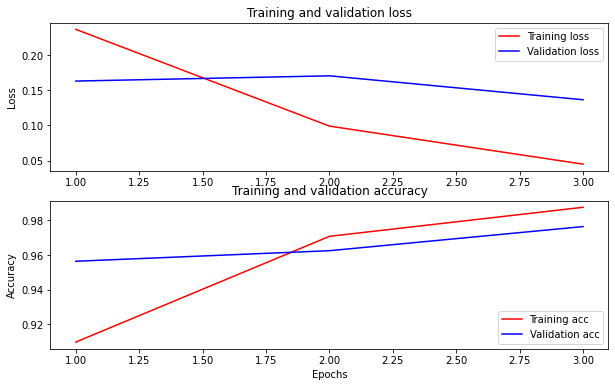

In [29]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [30]:
##re-test on test_ds

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

1034/1034 [==============================] - 30s 28ms/step - loss: 0.1377 - binary_accuracy: 0.9749
Loss: 0.13769611716270447
Accuracy: 0.9748549461364746


In [31]:
y_pred = classifier_model.predict(testdf['feature'])
y_pred = y_pred.reshape(1034)
y_pred = np.asarray(tf.round(tf.nn.sigmoid(y_pred)))

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [33]:
print(classification_report(testdf['include'], y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       829
           1       0.93      0.95      0.94       205

    accuracy                           0.97      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.98      0.97      0.97      1034



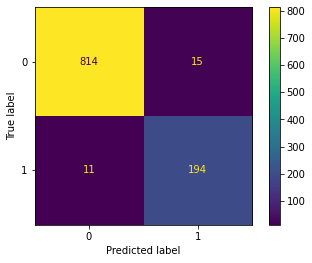

In [34]:
cm = ConfusionMatrixDisplay(confusion_matrix(testdf['include'], y_pred))

cm.plot()

In [35]:
testdf.loc[:,'predicted'] = np.asarray(y_pred)

C:\Users\Joe Z\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [36]:
np.asarray(y_pred).shape

(1034,)

In [37]:
misclassified = testdf[testdf.include != testdf.predicted]
misclassified.to_csv('bert_misclassified.csv')

In [38]:
import finish_early as now

ModuleNotFoundError: No module named 'finish_early'

## Save model

In [39]:
#EXPORT MODEL

saved_model_path = 'models/ai_literature_bert'

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
#EXPORT MODEL2
#
#saved_model_path = 'models/ai_literature_bert_optimizer'
#
#classifier_model.save(saved_model_path, include_optimizer=True)